# MANA Photosensitizer Property Prediction
## Complete Training Pipeline for Google Colab

This notebook contains the complete MANA training pipeline, including:
1. Google Drive mounting for data/model persistence
2. All model architecture code (PaiNN-based GNN)
3. Dataset loading and preprocessing
4. Training engine with LR scheduling
5. Two-phase training: Lambda (pre-training) → Phi (fine-tuning)

### Prerequisites
- Upload your `.h5` dataset files to Google Drive:
  - `lambdamax_data.h5`
  - `phi_data.h5`
- Set the `DRIVE_DATA_PATH` variable below to point to your data folder

---
## 1. Setup & Configuration

In [3]:
# ============================================================================
# CONFIGURATION - Edit these paths to match your Google Drive structure
# ============================================================================

# Path to your data folder in Google Drive (relative to /content/drive/MyDrive/)
DRIVE_DATA_PATH = "MANA/data"

# Path where models will be saved in Google Drive
DRIVE_MODELS_PATH = "MANA/models"

# Dataset filenames
LAMBDA_DATASET_FILENAME = "lambdamax_data.h5"
FLUOR_DATASET_FILENAME = "fluor_data.h5"
PHI_DATASET_FILENAME = "phidelta_data.h5"

# ============================================================================
# MODEL CONFIGURATION
# ============================================================================
# Universal atom type count - must be consistent across all training phases
# Set this to cover all atoms in BOTH datasets (e.g., 54 covers H through I)
NUM_ATOM_TYPES = 118

In [4]:
# ============================================================================
# Mount Google Drive
# ============================================================================
from google.colab import drive
drive.mount('/content/drive')

import os
from pathlib import Path

# Build full paths
DRIVE_ROOT = Path("/content/drive/MyDrive")
DATA_DIR = DRIVE_ROOT / DRIVE_DATA_PATH
MODELS_DIR = DRIVE_ROOT / DRIVE_MODELS_PATH

LAMBDA_DATASET_PATH = DATA_DIR / LAMBDA_DATASET_FILENAME
FLUOR_DATASET_PATH = DATA_DIR / FLUOR_DATASET_FILENAME
PHI_DATASET_PATH = DATA_DIR / PHI_DATASET_FILENAME

# Create model directories
SAVE_DIR_LAMBDA = MODELS_DIR / "lambda"
SAVE_DIR_FLUOR = MODELS_DIR / "fluor"
SAVE_DIR_PHI = MODELS_DIR / "phi"
os.makedirs(SAVE_DIR_LAMBDA, exist_ok=True)
os.makedirs(SAVE_DIR_FLUOR, exist_ok=True)
os.makedirs(SAVE_DIR_PHI, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Models directory: {MODELS_DIR}")
print(f"Lambda dataset: {LAMBDA_DATASET_PATH}")
print(f"Fluorescence dataset: {FLUOR_DATASET_PATH}")
print(f"Phi dataset: {PHI_DATASET_PATH}")
print()
print(f"Lambda dataset exists: {LAMBDA_DATASET_PATH.exists()}")
print(f"Fluorescence dataset exists: {FLUOR_DATASET_PATH.exists()}")
print(f"Phi dataset exists: {PHI_DATASET_PATH.exists()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data directory: /content/drive/MyDrive/MANA/data
Models directory: /content/drive/MyDrive/MANA/models
Lambda dataset: /content/drive/MyDrive/MANA/data/lambdamax_data.h5
Fluorescence dataset: /content/drive/MyDrive/MANA/data/fluor_data.h5
Phi dataset: /content/drive/MyDrive/MANA/data/phidelta_data.h5

Lambda dataset exists: True
Fluorescence dataset exists: True
Phi dataset exists: True


In [5]:
# ============================================================================
# Install Dependencies
# ============================================================================
!pip install torch-geometric h5py -q

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.5 MB/s eta 0:00:00
PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


---
## 2. Model Architecture (MANA with PaiNN)

In [6]:
# ============================================================================
# MANA Model Architecture
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F


def scatter_sum(src, index, dim=-1, dim_size=None):
    """
    Native PyTorch implementation of scatter_sum to avoid torch_scatter dependency
    which often hangs on macOS (Apple Silicon).
    """
    if dim_size is None:
        dim_size = index.max().item() + 1

    # Create the output tensor of zeros
    size = list(src.size())
    size[dim] = dim_size
    out = torch.zeros(size, dtype=src.dtype, device=src.device)

    # index_add_ expects the index to have the same number of dimensions as src?
    # No, index_add_ expects a 1D index tensor.
    # We just need to ensure shapes match for the operation.
    return out.index_add_(dim, index, src)


class RadialBasisFunction(nn.Module):
    """
    Module to compute radial basis functions (RBFs) for given distances.
    Uses Gaussian RBFs centered at specified points with given widths.
    """

    def __init__(self, num_rbf, cutoff=5.0):
        """
        num_rbf: Number of radial basis functions.
        cutoff: Cutoff distance for the RBFs.
        """

        super().__init__()
        centers = torch.linspace(0.0, cutoff, num_rbf)
        self.register_buffer("centers", centers)
        self.gamma = nn.Parameter(torch.ones(num_rbf), requires_grad=False)

    def forward(self, distances):
        """
        Defines the forward pass to compute RBFs.
        distances: Tensor of shape (num_edges,) containing distances.
        Returns: Tensor of shape (num_edges, num_rbf) containing RBF values.
        """

        diff = distances.unsqueeze(-1) - self.centers
        return torch.exp(-self.gamma * diff**2)


class PaiNNLayer(nn.Module):
    """
    A single layer of the PaiNN architecture.
    """

    def __init__(self, hidden_dim, num_rbf):
        """
        Initializes the PaiNN layer.
        hidden_dim: Dimension of the hidden features.
        num_rbf: Number of radial basis functions.
        """

        super().__init__()

        self.filter_net = nn.Sequential(
            nn.Linear(num_rbf, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 3 * hidden_dim),
        )

        self.update_net = nn.Sequential(
            nn.Linear(3 * hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 3 * hidden_dim),
        )

    def forward(self, s, v, edge_index, edge_attr, rbf):
        """
        PaiNN message passing with strict E(3)-equivariance.

        s: (N, F) scalar features
        v: (N, F, 3) vector features
        edge_index: (2, E)
        edge_attr: (E, 4) = (distance, dx, dy, dz)
        rbf: (E, num_rbf)
        """

        row, col = edge_index
        directions = edge_attr[:, 1:4]  # (E, 3)

        phi_ss, phi_vv, phi_sv = self.filter_net(rbf).chunk(3, dim=-1)

        m_s = phi_ss * s[col]
        m_v = phi_vv.unsqueeze(-1) * v[col] + phi_sv.unsqueeze(
            -1
        ) * directions.unsqueeze(1) * s[col].unsqueeze(-1)

        m_s = scatter_sum(m_s, row, dim=0, dim_size=s.size(0))
        m_v = scatter_sum(m_v, row, dim=0, dim_size=v.size(0))

        v_norm = torch.norm(m_v, dim=-1)
        delta_s, alpha, beta = self.update_net(
            torch.cat([s, m_s, v_norm], dim=-1)
        ).chunk(3, dim=-1)

        s = s + delta_s
        v = alpha.unsqueeze(-1) * v + beta.unsqueeze(-1) * m_v

        return s, v


class LambdaMaxHead(nn.Module):
    """
    Predicts absorption maximum (lambda_max) from molecular embedding
    """

    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, h_mol):
        """
        h_mol: (num_molecules, hidden_dim) molecular embeddings
        returns: (num_molecules, 1) lambda_max
        """
        return self.net(h_mol)


class PhiDeltaHead(nn.Module):
    """
    Predicts a singlet oxygen from molecular embedding
    """

    def __init__(self, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, 1),
        )
        # Softplus followed by Sigmoid: Softplus avoids sharp negative saturation while
        # Sigmoid bounds the output to (0, 1) which helps prevent prediction clustering.
        self.activation = nn.Sigmoid()

    def forward(self, h_mol):
        """
        h_mol: (num_molecules, hidden_dim) molecular embeddings
        returns: (num_molecules, 1) singlet oxygen yield (non-negative, can exceed 1.0)
        """
        return self.activation(self.net(h_mol))


class MANA(nn.Module):
    def __init__(
        self,
        num_atom_types,
        hidden_dim=128,
        num_layers=4,
        num_rbf=20,
        tasks=None,
        lambda_mean=500.0,
        lambda_std=100.0,
    ):
        super().__init__()
        if tasks is None:
            tasks = ["lambda", "phi"]
        self.tasks = tasks

        self.embedding = nn.Embedding(num_atom_types, hidden_dim)
        self.rbf = RadialBasisFunction(num_rbf)
        self.layers = nn.ModuleList(
            [PaiNNLayer(hidden_dim, num_rbf) for _ in range(num_layers)]
        )

        # Takes only the molecule embedding (128)
        self.lambda_head = LambdaMaxHead(hidden_dim)

        solvent_dim = 64
        # Encodes Dielectric Constant (1 float) -> Vector (64)
        self.solvent_encoder = nn.Sequential(
            nn.Linear(1, solvent_dim), nn.SiLU(), nn.Linear(solvent_dim, solvent_dim)
        )

        # Phi Head takes (Mol_Emb + Solv_Emb) = 128 + 64
        self.phi_head = PhiDeltaHead(hidden_dim + solvent_dim)

        self._init_weights()

        self.register_buffer("lambda_mean", torch.tensor(lambda_mean))
        self.register_buffer("lambda_std", torch.tensor(lambda_std))

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

        if hasattr(self, "phi_head"):
            final_layer = self.phi_head.net[-1]
            if isinstance(final_layer, nn.Linear):
                nn.init.constant_(final_layer.bias, -2.0) # Sigmoid(-2.0) ≈ 0.12

    def forward(self, data):
        z, edge_index, edge_attr, batch = (
            data.x,
            data.edge_index,
            data.edge_attr,
            data.batch,
        )

        # 1. Run Backbone
        dist = edge_attr[:, 0]
        rbf = self.rbf(dist)
        s = self.embedding(z)
        v = torch.zeros(s.size(0), s.size(1), 3, device=s.device)

        for layer in self.layers:
            s, v = layer(s, v, edge_index, edge_attr, rbf)

        # Molecular Embedding
        h_mol = scatter_sum(s, batch, dim=0)
        h_mol = h_mol / (torch.bincount(batch).unsqueeze(-1).float() + 1e-9)

        results = {}

        # 2. Lambda Head (Standard)
        if "lambda" in self.tasks:
            results["lambda"] = self.lambda_head(h_mol).squeeze(-1)

        # 3. Phi Head (Solvent Aware)
        if "phi" in self.tasks:
            # Expecting data.dielectric to be shape (Batch_Size, 1)
            if not hasattr(data, "dielectric"):
                raise ValueError("Model expects 'data.dielectric' attribute!")

            h_solv = self.solvent_encoder(data.dielectric)

            # Concatenate [Molecule, Solvent]
            h_combined = torch.cat([h_mol, h_solv], dim=1)
            results["phi"] = self.phi_head(h_combined).squeeze(-1)

        return results

    def loss_fn(self, preds, batch):
        """
        Defines the loss function for training.
        preds: Tuple of model predictions (lambda_max, phi_delta)
        batch: Batch of data with ground truth values:
            - batch.lambda_max : (B,) or NaN
            - batch.phi_delta  : (B,) or NaN
        Returns:
            - total_loss: Weighted sum of individual losses.
            - loss_lambda: Absorption maximum loss.
            - loss_phi: Singlet oxygen yield loss.
        """
        loss = 0
        metrics = {}

        if "lambda" in self.tasks and hasattr(batch, "lambda_max"):
            mask = torch.isfinite(batch.lambda_max.squeeze())
            if mask.any():
                pred_norm = (preds["lambda"][mask] - self.lambda_mean) / self.lambda_std
                target_norm = (
                    batch.lambda_max[mask] - self.lambda_mean
                ) / self.lambda_std

                loss_lambda = F.huber_loss(pred_norm, target_norm, delta=1.0)
                loss += loss_lambda
                metrics["loss_lambda"] = loss_lambda.item()

        if "phi" in self.tasks and hasattr(batch, "phi_delta"):
            mask = torch.isfinite(batch.phi_delta.squeeze())
            # if mask.sum() > 1:
            #     phi_pred = preds["phi"][mask]
            #     phi_true = batch.phi_delta[mask]

            #     diff_pred = phi_pred.unsqueeze(1) - phi_pred.unsqueeze(0)
            #     diff_true = phi_true.unsqueeze(1) - phi_true.unsqueeze(0)

            #     loss_phi = F.relu(-diff_pred * diff_true).mean()
            #     loss += loss_phi
            #     metrics["loss_phi"] = loss_phi.item()
            if mask.any():
                # Use Huber loss for robustness to outliers in phi values
                loss_phi = F.huber_loss(
                    preds["phi"][mask], batch.phi_delta[mask], delta=0.5
                )
                loss += loss_phi
                metrics["loss_phi"] = loss_phi.item()

        return loss, metrics

    def freeze_backbone(self):
        """
        Freeze the backbone layers (embedding, RBF, PaiNN layers, lambda_head).
        Only phi_head and solvent_encoder remain trainable.
        """
        for param in self.embedding.parameters():
            param.requires_grad = False
        for param in self.rbf.parameters():
            param.requires_grad = False
        for param in self.layers.parameters():
            param.requires_grad = False
        for param in self.lambda_head.parameters():
            param.requires_grad = False
        print("✓ Backbone frozen (embedding + RBF + PaiNN layers + lambda_head)")



print("✓ MANA model architecture loaded")

✓ MANA model architecture loaded


---
## 3. Dataset Loading

In [7]:
# ============================================================================
# Dataset Constructor
# ============================================================================

import h5py
import numpy as np
import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from tqdm import tqdm  # Add progress bar for startup


class GeometricSubset:
    """
    Wrapper to handle train/val/test splits for the dataset.
    """

    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Fetch directly from the parent dataset's pre-computed list
        return self.dataset[self.indices[idx]]


class DatasetConstructor(Dataset):
    def __init__(
        self,
        hdf5_file,
        cutoff_radius=5.0,
        batch_size=32,
        train_split=0.8,
        val_split=0.1,
        random_seed=42,
        num_atom_types=None,
        split_by_mol_id=False,
    ):
        super().__init__()

        print(f"Loading raw data from {hdf5_file}...")
        with h5py.File(hdf5_file, "r") as f:
            self.atomic_numbers = f["atomic_numbers"][()]  # pyright: ignore[reportIndexIssue]
            self.positions = f["geometries"][()]  # pyright: ignore[reportIndexIssue]
            self.lambda_max = f["lambda_max"][()]  # pyright: ignore[reportIndexIssue]
            self.phi_delta = f["phi_delta"][()]  # pyright: ignore[reportIndexIssue]
            self.mol_ids = f["mol_ids"][()]  # pyright: ignore[reportIndexIssue]
            self.dielectric = f["dielectric"][()]  # pyright: ignore[reportIndexIssue]

            raw_smiles = f["smiles"][()]  # pyright: ignore[reportIndexIssue]
            self.smiles = [
                s.decode("utf-8") if isinstance(s, bytes) else s for s in raw_smiles
            ]  # pyright: ignore[reportGeneralTypeIssues]

        # 1. Build Vocabulary
        unique_atoms = set()
        for z in self.atomic_numbers:  # pyright: ignore[reportGeneralTypeIssues]
            unique_atoms.update(z[z > 0])  # Ignore padding (0)

        self.unique_atoms = sorted(list(unique_atoms))
        self.atom_to_index = {a: i + 1 for i, a in enumerate(self.unique_atoms)}

        self.num_atom_types = (
            num_atom_types if num_atom_types is not None else len(self.unique_atoms) + 1
        )

        self.cutoff_radius = cutoff_radius
        self.batch_size = batch_size
        self.n_structures = self.atomic_numbers.shape[0]  # pyright: ignore[reportAttributeAccessIssue]

        # 2. PRE-COMPUTE GRAPHS (The Speed Fix)
        # We process all molecules into PyG Data objects right now
        print(
            f"Pre-processing {self.n_structures} molecular graphs (this speeds up training)..."
        )
        self.data_list = []

        for idx in tqdm(range(self.n_structures)):
            data_obj = self._process_one(idx)
            self.data_list.append(data_obj)

        # 3. Create Splits
        np.random.seed(random_seed)
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed_all(random_seed)

        if split_by_mol_id:
            # Split by molecule ID to prevent data leakage with augmented datasets
            # All conformers of the same molecule stay in the same split
            unique_mol_ids = np.unique(self.mol_ids)
            np.random.shuffle(unique_mol_ids)

            n_mol_train = int(train_split * len(unique_mol_ids))
            n_mol_val = int(val_split * len(unique_mol_ids))

            train_mol_ids = set(unique_mol_ids[:n_mol_train])
            val_mol_ids = set(unique_mol_ids[n_mol_train : n_mol_train + n_mol_val])
            test_mol_ids = set(unique_mol_ids[n_mol_train + n_mol_val :])

            # Map back to sample indices
            self.train_indices = np.array(
                [
                    i
                    for i in range(self.n_structures)
                    if self.mol_ids[i] in train_mol_ids
                ]
            )
            self.val_indices = np.array(
                [i for i in range(self.n_structures) if self.mol_ids[i] in val_mol_ids]
            )
            self.test_indices = np.array(
                [i for i in range(self.n_structures) if self.mol_ids[i] in test_mol_ids]
            )

            print(f"Split by mol_id: {len(unique_mol_ids)} unique molecules")
            print(
                f"  Train: {len(train_mol_ids)} molecules -> {len(self.train_indices)} samples"
            )
            print(
                f"  Val:   {len(val_mol_ids)} molecules -> {len(self.val_indices)} samples"
            )
            print(
                f"  Test:  {len(test_mol_ids)} molecules -> {len(self.test_indices)} samples"
            )
        else:
            # Random split by sample (original behavior)
            idx = np.random.permutation(self.n_structures)

            n_train = int(train_split * self.n_structures)
            n_val = int(val_split * self.n_structures)

            self.train_indices = idx[:n_train]
            self.val_indices = idx[n_train : n_train + n_val]
            self.test_indices = idx[n_train + n_val :]

        train_lambda = self.lambda_max[self.train_indices]  # pyright: ignore[reportIndexIssue]

        self.lambda_mean = np.mean(train_lambda)  # pyright: ignore[reportCallIssue, reportArgumentType]
        self.lambda_std = np.std(train_lambda)  # pyright: ignore[reportCallIssue, reportArgumentType]

    def _process_one(self, idx):
        """Internal helper to process a single molecule index into a Data object"""

        z_raw = self.atomic_numbers[idx]  # pyright: ignore[reportIndexIssue]

        # Map atoms
        z = torch.tensor(
            [self.atom_to_index[a] if a > 0 else 0 for a in z_raw],  # pyright: ignore[reportGeneralTypeIssues]
            dtype=torch.long,
        )

        pos = torch.tensor(self.positions[idx], dtype=torch.float32)  # pyright: ignore[reportIndexIssue]
        atom_mask = torch.tensor(z_raw > 0, dtype=torch.bool)  # pyright: ignore[reportOperatorIssue]

        # Squeeze out padding NOW so the model doesn't process ghost atoms
        # This makes the tensors smaller and faster
        real_mask = atom_mask
        z = z[real_mask]
        pos = pos[real_mask]

        # Generate Edges
        # Since we removed padding, we don't need to filter creating edges
        # We just compute distances on the real atoms
        if pos.size(0) == 0:
            edge_index = torch.emptyd((2, 0), dtype=torch.long)
            edge_attr = torch.empty((0, 4))
        else:
            dist = torch.cdist(pos, pos)
            mask = (dist < self.cutoff_radius) & (dist > 0)
            row, col = mask.nonzero(as_tuple=True)
            edge_index = torch.stack([row, col], dim=0)

            diff = pos[col] - pos[row]
            d = torch.norm(diff, dim=1, keepdim=True)
            u = diff / (d + 1e-8)
            edge_attr = torch.cat([d, u], dim=1)

        return Data(
            x=z,
            pos=pos,
            edge_index=edge_index,
            edge_attr=edge_attr,
            lambda_max=torch.tensor([self.lambda_max[idx]], dtype=torch.float32),  # pyright: ignore[reportIndexIssue]
            phi_delta=torch.tensor([self.phi_delta[idx]], dtype=torch.float32),  # pyright: ignore[reportIndexIssue]
            mol_id=torch.tensor([self.mol_ids[idx]], dtype=torch.int32),  # pyright: ignore[reportIndexIssue]
            dielectric=torch.tensor([self.dielectric[idx]], dtype=torch.float32).view(
                1, 1
            ),  # pyright: ignore[reportIndexIssue]
            smiles=self.smiles[idx],
        )

    def len(self):
        return self.n_structures

    def get(self, idx):
        return self.data_list[idx]

    # Required for the subset wrapper to work nicely via indexing
    def __getitem__(self, idx):
        return self.data_list[idx]  # pyright: ignore[reportArgumentType, reportCallIssue]

    def get_dataloaders(self, num_workers=0):
        # Since data is pre-loaded in RAM, num_workers=0 is usually fastest!
        return (
            DataLoader(
                GeometricSubset(self, self.train_indices),  # pyright: ignore[reportArgumentType]
                batch_size=self.batch_size,
                shuffle=True,
                num_workers=num_workers,
            ),
            DataLoader(
                GeometricSubset(self, self.val_indices),  # pyright: ignore[reportArgumentType]
                batch_size=self.batch_size,
                shuffle=False,
                num_workers=num_workers,
            ),
            DataLoader(
                GeometricSubset(self, self.test_indices),  # pyright: ignore[reportArgumentType]
                batch_size=self.batch_size,
                shuffle=False,
                num_workers=num_workers,
            ),
        )


print("✓ Dataset constructor loaded")

✓ Dataset constructor loaded


---
## 4. Training Engine

In [8]:
# ============================================================================
# Training Engine
# ============================================================================

import os

import matplotlib
import numpy as np
import torch
from torch.optim.adam import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

# Use non-interactive backend so training on headless machines works
matplotlib.use("Agg")
import matplotlib.pyplot as plt


class TrainingEngine:
    def __init__(
        self,
        model,
        device,
        train_loader,
        val_loader,
        hyperparams,
        save_dir,
    ):
        self.model = model.to(device)
        self.device = device
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.save_dir = save_dir

        self.max_epochs = hyperparams["max_epochs"]
        self.patience = hyperparams["early_stopping_patience"]

        # Only optimize parameters that require gradients (supports frozen backbone)
        self.optimizer = Adam(
            filter(lambda p: p.requires_grad, self.model.parameters()),
            lr=hyperparams["learning_rate"],
            weight_decay=hyperparams["weight_decay"],
        )

        self.scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode="min",
            factor=0.5,
            patience=20,
            min_lr=1e-6,
        )

        os.makedirs(save_dir, exist_ok=True)

        # History for plotting and analysis
        self.history = {
            "train_total": [],
            "val_total": [],
            "train_lambda": [],
            "train_phi": [],
            "val_lambda": [],
            "val_phi": [],
        }

    def train(self):
        best_val = float("inf")
        patience_counter = 0

        for epoch in range(1, self.max_epochs + 1):
            train_total, train_comps = self._train_epoch()
            val_total, val_comps = self._validate()

            # store history
            self.history["train_total"].append(train_total)
            self.history["val_total"].append(val_total)

            self.history["train_lambda"].append(train_comps.get("loss_lambda", 0))
            self.history["train_phi"].append(train_comps.get("loss_phi", 0))
            self.history["val_lambda"].append(val_comps.get("loss_lambda", 0))
            self.history["val_phi"].append(val_comps.get("loss_phi", 0))

            # Step the learning rate scheduler
            self.scheduler.step(val_total)

            # Print totals and components for transparency
            current_lr = self.optimizer.param_groups[0]["lr"]
            lam_str = f"λ={train_comps.get('loss_lambda', 0):.2f}"
            phi_str = f"φ={train_comps.get('loss_phi', 0):.4f}"

            val_lam_str = f"λ={val_comps.get('loss_lambda', 0):.2f}"
            val_phi_str = f"φ={val_comps.get('loss_phi', 0):.4f}"

            print(
                f"Epoch {epoch:4d} | "
                f"Train: {train_total:.4f} ({lam_str}, {phi_str}) | "
                f"Val: {val_total:.4f} ({val_lam_str}, {val_phi_str}) | "
                f"LR: {current_lr:.2e}"
            )

            # checkpointing based on validation total loss
            if val_total < best_val:
                best_val = val_total
                patience_counter = 0
                torch.save(
                    self.model.state_dict(),
                    os.path.join(self.save_dir, "best_model.pth"),
                )
            else:
                patience_counter += 1

            if patience_counter >= self.patience:
                print("Early stopping triggered.")
                break

        # After training, save and plot loss curves
        try:
            self._plot_losses()
            print(f"Saved loss history and plots to: {self.save_dir}")
        except Exception as e:
            # don't crash training if plotting fails; just report
            print(f"Warning: failed to save/plot losses: {e}")

    def _train_epoch(self):
        self.model.train()
        total_loss = 0.0
        accumulators = {}
        n_batches = 0

        pbar = tqdm(self.train_loader, desc="Training", leave=False)

        for i, batch in enumerate(pbar):
            batch = batch.to(self.device)

            preds = self.model(batch)

            loss, metrics = self.model.loss_fn(preds, batch)

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()

            total_loss += loss.item()
            for k, v in metrics.items():
                accumulators[k] = accumulators.get(k, 0.0) + v
            n_batches += 1

            current_lam = metrics.get("loss_lambda", 0.0)
            current_phi = metrics.get("loss_phi", 0.0)
            pbar.set_postfix(
                {
                    "Loss": f"{loss.item():.2f}",
                    "λ": f"{current_lam:.1f}",
                    "φ": f"{current_phi:.4f}",
                }
            )

        if n_batches == 0:
            return 0.0, {}

        self._save_history()

        avg_metrics = {k: v / n_batches for k, v in accumulators.items()}
        return total_loss / n_batches, avg_metrics

    @torch.no_grad()
    def _validate(self):
        self.model.eval()

        total_loss = 0.0

        accumulators = {}

        n_batches = 0

        for batch in self.val_loader:
            batch = batch.to(self.device)
            preds = self.model(batch)
            loss, metrics = self.model.loss_fn(preds, batch)

            total_loss += loss.item()

            for k, v in metrics.items():
                accumulators[k] = accumulators.get(k, 0.0) + v

            n_batches += 1

        if n_batches == 0:
            return 0.0, {}

        self._save_history()

        # Average out
        avg_metrics = {k: v / n_batches for k, v in accumulators.items()}
        return total_loss / n_batches, avg_metrics

    def _save_history(self):
        # Convert lists to numpy arrays and save
        save_dict = {k: np.array(v) for k, v in self.history.items()}
        np.savez_compressed(
            os.path.join(self.save_dir, "loss_history.npz"),
            **save_dict,  # pyright:ignore[reportArgumentType]
        )

    def _plot_losses(self):
        epochs = np.arange(1, len(self.history["train_total"]) + 1)

        # Create 2 subplots so the scales don't mess each other up
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        # Plot 1: Lambda Max (High values)
        ax1.plot(
            epochs,
            self.history["train_lambda"],
            label="Train Lambda",
            color="tab:purple",
        )
        ax1.plot(
            epochs,
            self.history["val_lambda"],
            "--",
            label="Val Lambda",
            color="tab:purple",
        )
        ax1.set_title("Absorption (Lambda) Loss")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Huber Loss")
        ax1.legend()
        ax1.grid(True)

        # Plot 2: Phi (Low values)
        ax2.plot(
            epochs, self.history["train_phi"], label="Train Phi", color="tab:brown"
        )
        ax2.plot(
            epochs, self.history["val_phi"], "--", label="Val Phi", color="tab:brown"
        )
        ax2.set_title("Quantum Yield (Phi) Loss")
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Huber Loss")
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()

        # FIX: Just use a relative filename. It will save inside self.save_dir automatically.
        fig_path = os.path.join(self.save_dir, "loss_curves.png")
        plt.savefig(fig_path)
        plt.close()


print("✓ Training engine loaded")

✓ Training engine loaded


---
## 5. Phase 1: Train Lambda Head (Pre-training)

In [9]:
def train_head(hyperparams, dataset_path, save_dir, split_by_mol_id, load_model, model_path, freeze_backbone=False):
    head = hyperparams["tasks"][0]
    print("\n" + "=" * 80)
    print(f"TRAINING {head.upper()} HEAD")
    print("=" * 80)

    print(f"Dataset: {dataset_path}")
    print(f"Save Dir: {save_dir}")
    print(f"Freeze Backbone: {freeze_backbone}")

    if not os.path.exists(dataset_path):
        print(f"ERROR: Dataset not found at {dataset_path}")
        print(f"Please run the corresponding build script first.")
        sys.exit(1)

    # ------------------------------------------------------------------
    # Dataset
    # ------------------------------------------------------------------
    # Using 'split_by_mol_id=True' is generally safer for chemistry to avoid
    # data leakage between conformers of the same molecule.
    dataset = DatasetConstructor(
        str(dataset_path),
        cutoff_radius=5.0,
        batch_size=64,
        train_split=0.8,
        val_split=0.1,
        random_seed=42,
        split_by_mol_id=split_by_mol_id,
    )

    train_loader, val_loader, _ = dataset.get_dataloaders(num_workers=0)

    # Handle NaN means (Phase 3 dataset has no valid Lambda Max)
    l_mean = dataset.lambda_mean
    l_std = dataset.lambda_std
    if np.isnan(l_mean):
        l_mean = 500.0
        l_std = 100.0

    # ------------------------------------------------------------------
    # Model
    # ------------------------------------------------------------------
    model = MANA(
        num_atom_types=NUM_ATOM_TYPES,
        hidden_dim=128,
        num_layers=4,
        num_rbf=20,
        tasks=hyperparams["tasks"],
        lambda_mean=l_mean,
        lambda_std=l_std,
    )

    if load_model:
        print(f"Loading weights from: {model_path}")
        # strict=False allows us to load the backbone even if we are switching heads
        model.load_state_dict(
            torch.load(model_path, map_location=torch.device('cpu')), strict=False
        )

    if freeze_backbone:
        print("Freezing Backbone Layers...")
        model.freeze_backbone()

    # Device Selection
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
    else:
        device = torch.device("cpu")

    model = model.to(device)

    # ------------------------------------------------------------------
    # Training Engine
    # ------------------------------------------------------------------
    engine = TrainingEngine(
        model=model,
        device=device,
        train_loader=train_loader,
        val_loader=val_loader,
        hyperparams=hyperparams,
        save_dir=str(save_dir),
    )

    # ------------------------------------------------------------------
    # Configuration summary
    # ------------------------------------------------------------------
    print("-" * 60)
    print(f"Device: {device}")
    print(f"Learning rate: {hyperparams['learning_rate']}")
    print(f"Max epochs: {hyperparams['max_epochs']}")
    print(f"Weight Decay: {hyperparams['weight_decay']}")
    print("-" * 60)

    # ------------------------------------------------------------------
    # Train
    # ------------------------------------------------------------------
    try:
        engine.train()
        print(f"\nPhase complete. Best model saved to {save_dir}/best_model.pth")
    except KeyboardInterrupt:
        print("\nTraining interrupted by user.")
    except Exception as e:
        print(f"\nTraining failed with error:\n{e}")
        import traceback
        traceback.print_exc()

In [10]:
lambda_hyperparams = {
        "learning_rate": 1e-3,     # Fast learning for large dataset
        "max_epochs": 200,         # 200 is usually enough for convergence
        "early_stopping_patience": 60,
        "weight_decay": 1e-5,      # Standard regularization
        "tasks": ["lambda"],
    }

train_head(
    lambda_hyperparams,
    LAMBDA_DATASET_PATH,
    SAVE_DIR_LAMBDA,
    split_by_mol_id=False,
    load_model=False,
    model_path=None,
    freeze_backbone=False
)


TRAINING LAMBDA HEAD
Dataset: /content/drive/MyDrive/MANA/data/lambdamax_data.h5
Save Dir: /content/drive/MyDrive/MANA/models/lambda
Freeze Backbone: False
Loading raw data from /content/drive/MyDrive/MANA/data/lambdamax_data.h5...
Pre-processing 17687 molecular graphs (this speeds up training)...


100%|██████████| 17687/17687 [00:13<00:00, 1352.37it/s]


------------------------------------------------------------
Device: cuda
Learning rate: 0.001
Max epochs: 200
Weight Decay: 1e-05
------------------------------------------------------------



Training interrupted by user.


In [12]:
fluor_hyperparams = {
        "learning_rate": 1e-4,     # 10x slower to preserve features
        "max_epochs": 200,
        "early_stopping_patience": 25,
        "weight_decay": 1e-5,
        "tasks": ["phi"],          # Re-purposing the Phi head
    }

p1_model_path = SAVE_DIR_LAMBDA / "best_model.pth"
if p1_model_path.exists():
    train_head(
        fluor_hyperparams,
        FLUOR_DATASET_PATH,
        SAVE_DIR_FLUOR,
        split_by_mol_id=True,
        load_model=True,
        model_path=p1_model_path,
        freeze_backbone=False  # Unfrozen: Allow backbone to learn Emission physics
    )
else:
    print("Skipping Phase 2 (Phase 1 model not found)")


TRAINING PHI HEAD
Dataset: /content/drive/MyDrive/MANA/data/fluor_data.h5
Save Dir: /content/drive/MyDrive/MANA/models/fluor
Freeze Backbone: False
Loading raw data from /content/drive/MyDrive/MANA/data/fluor_data.h5...
Pre-processing 13962 molecular graphs (this speeds up training)...


100%|██████████| 13962/13962 [00:09<00:00, 1493.07it/s]


Split by mol_id: 13962 unique molecules
  Train: 11169 molecules -> 11169 samples
  Val:   1396 molecules -> 1396 samples
  Test:  1397 molecules -> 1397 samples
Loading weights from: /content/drive/MyDrive/MANA/models/lambda/best_model.pth
------------------------------------------------------------
Device: cuda
Learning rate: 0.0001
Max epochs: 200
Weight Decay: 1e-05
------------------------------------------------------------



Training interrupted by user.


In [13]:
phi_hyperparams = {
        "learning_rate": 5e-5,     # Very slow fine-tuning
        "max_epochs": 150,         # Shorter run for small data
        "early_stopping_patience": 20,
        "weight_decay": 1e-3,      # High regularization to prevent overfitting on small data
        "tasks": ["phi"],
    }

p2_model_path = SAVE_DIR_FLUOR / "best_model.pth"
if p2_model_path.exists():
    train_head(
        phi_hyperparams,
        PHI_DATASET_PATH,
        SAVE_DIR_PHI,
        split_by_mol_id=True,
        load_model=True,
        model_path=p2_model_path,
        freeze_backbone=True   # Frozen: Don't break the GNN on 1.4k samples
    )
else:
    print("Skipping Phase 3 (Phase 2 model not found)")


TRAINING PHI HEAD
Dataset: /content/drive/MyDrive/MANA/data/phidelta_data.h5
Save Dir: /content/drive/MyDrive/MANA/models/phi
Freeze Backbone: True
Loading raw data from /content/drive/MyDrive/MANA/data/phidelta_data.h5...
Pre-processing 2681 molecular graphs (this speeds up training)...


100%|██████████| 2681/2681 [00:01<00:00, 1497.48it/s]


Split by mol_id: 1309 unique molecules
  Train: 1047 molecules -> 2139 samples
  Val:   130 molecules -> 264 samples
  Test:  132 molecules -> 278 samples
Loading weights from: /content/drive/MyDrive/MANA/models/fluor/best_model.pth
Freezing Backbone Layers...
✓ Backbone frozen (embedding + RBF + PaiNN layers + lambda_head)
------------------------------------------------------------
Device: cuda
Learning rate: 5e-05
Max epochs: 150
Weight Decay: 0.001
------------------------------------------------------------


Epoch    1 | Train: 0.0566 (λ=0.00, φ=0.0566) | Val: 0.0490 (λ=0.00, φ=0.0490) | LR: 5.00e-05


Epoch    2 | Train: 0.0502 (λ=0.00, φ=0.0502) | Val: 0.0471 (λ=0.00, φ=0.0471) | LR: 5.00e-05



Training interrupted by user.


---
## 7. Summary & Saved Artifacts

In [14]:
# ============================================================================
# Training Complete - Summary
# ============================================================================

print("=" * 80)
print("TRAINING COMPLETE")
print("=" * 80)

print("\nSaved artifacts in Google Drive:")
print(f"\n📁 {SAVE_DIR_LAMBDA}")
for f in SAVE_DIR_LAMBDA.glob("*"):
    print(f"   └── {f.name}")

print(f"\n📁 {SAVE_DIR_PHI}")
for f in SAVE_DIR_PHI.glob("*"):
    print(f"   └── {f.name}")

print("\n" + "=" * 80)
print("You can now use the trained models for inference!")
print("=" * 80)

TRAINING COMPLETE

Saved artifacts in Google Drive:

📁 /content/drive/MyDrive/MANA/models/lambda
   └── best_model.pth

📁 /content/drive/MyDrive/MANA/models/phi
   └── best_model.pth
   └── loss_history.npz
   └── loss_curves.png

You can now use the trained models for inference!



Phi Training Loss Curves:


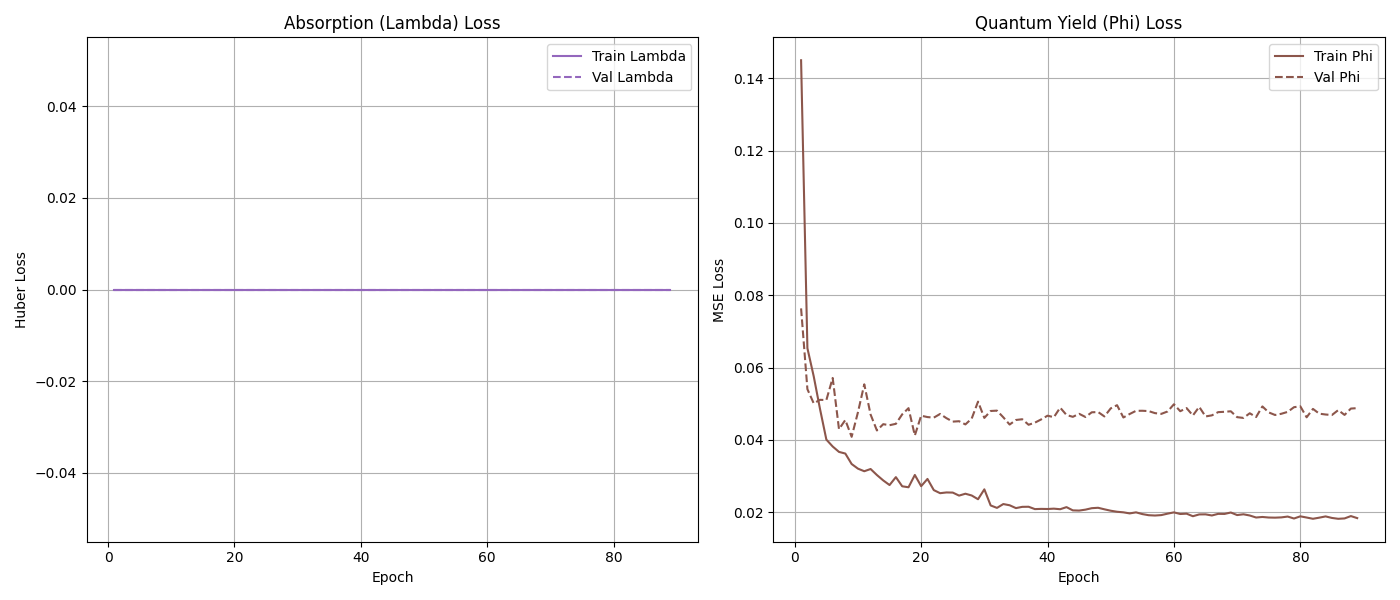

In [15]:
# Display loss curves if they exist
from IPython.display import Image, display

lambda_curves = SAVE_DIR_LAMBDA / "loss_curves.png"
phi_curves = SAVE_DIR_PHI / "loss_curves.png"

if lambda_curves.exists():
    print("Lambda Training Loss Curves:")
    display(Image(filename=str(lambda_curves)))

if phi_curves.exists():
    print("\nPhi Training Loss Curves:")
    display(Image(filename=str(phi_curves)))